In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import entropy, variation
import random

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins, nbrh_WG_open, mid_cum_Z4_sec
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
date_consistent_barn_schedule = config.date_consistent_barn_schedule
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
ALLDATA_


# Download data

In [4]:
#daily var
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
df_daily = df_daily[df_daily['level']!=dt.datetime(2021,7,25)]
print(df_daily.shape)
df_daily.head(3)

(39382, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


In [15]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer programe timing too
df_daily = df_daily[(df_daily['level']>config.date_consistent_barn_schedule)&\
                    (df_daily['level']<dt.datetime(2021,3,27,0,0,0))].copy()

In [ ]:
#add vertical travel distance during full light
df_daily['vertical_travel_distance_fulllight'] = df_daily.apply(lambda x: x['vertical_travel_distance']-x['vertical_travel_distance_dusk'], axis=1)
#we substract the dusk timing:
li_light_dusk_ = config.li_light_dusk_
nbr_dusk_sec = (max(li_light_dusk_)-min(li_light_dusk_)).seconds
print('dusk phase lasted for %d minutes' %(nbr_dusk_sec/60))
df_daily['vertical_travel_distance_fulllight_perinsideh'] = df_daily.apply(lambda x: x['vertical_travel_distance_fulllight']/(15-(x['duration_1_Zone']+nbr_dusk_sec)/60/60),axis=1)

In [17]:
print(df_daily.shape)
print(list(df_daily.columns))

(18819, 73)
['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'dur_values_normalized', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'food_related_behavior', 'food_related_behavior_rp', 'food_related_behavior_rm', 'food_related_behavior4', 'food_related_behavior_rp4', 'food_related_behavior_rm4', 'nestboxes_related_behavior', 'list_of_zones', 'list_ZALL', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'verti

# Option 1

In [70]:
df_daily.rename(columns={'food_related_behavior':'food_reactivity_index', 
                         'food_related_behavior_rp':'food_reactivity_index_forward',
                         'food_related_behavior_rm':'food_reactivity_index_backward'}, inplace=True)

,HenID,level,PenID,variable,food_behavior,is_negative
0,hen_131,2020-11-14,10,food_reactivity_index,0.141396,0
1,hen_131,2020-11-15,10,food_reactivity_index,0.156883,0
2,hen_131,2020-11-16,10,food_reactivity_index,-0.225432,1


,variable,level,is_negative
0,food_reactivity_index,2020-11-14,43.589744
1,food_reactivity_index,2020-11-15,35.256410
2,food_reactivity_index,2020-11-16,25.641026


,variable,mean_is_negative,sd_is_negative
0,food_reactivity_index,23.487334,4.199537
1,food_reactivity_index_backward,43.468028,5.386372
2,food_reactivity_index_forward,44.778291,4.401078


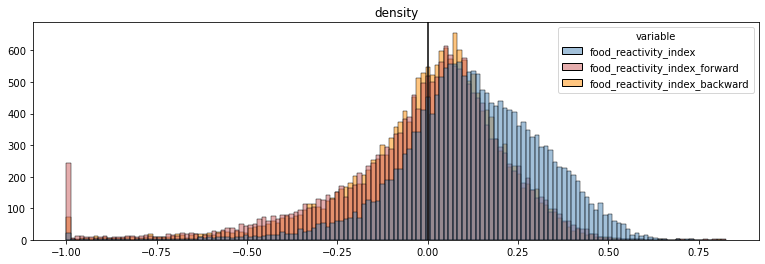

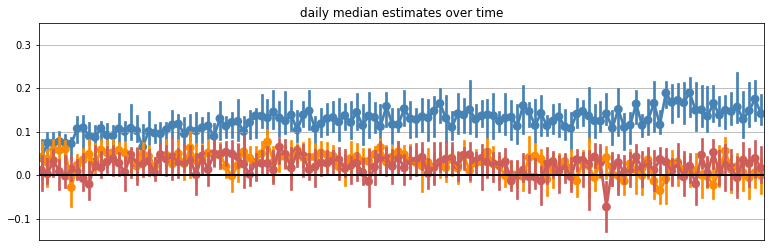

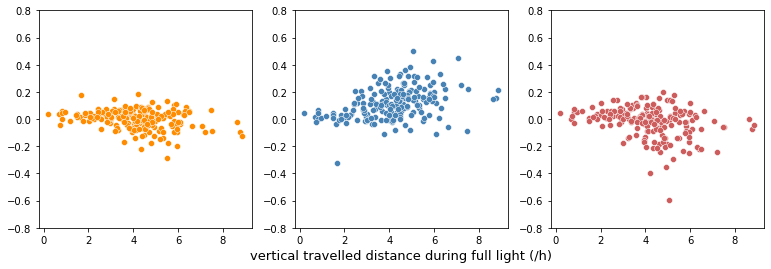

In [118]:
df_plt = pd.melt(df_daily, id_vars=['HenID','level','PenID'], 
        value_vars=['food_reactivity_index','food_reactivity_index_forward','food_reactivity_index_backward'],
        value_name='food_behavior')
df_plt['is_negative'] = df_plt['food_behavior'].map(lambda x: int(x<0))
display(df_plt.head(3))
df_plt_ = df_plt.groupby(['variable','level'])['is_negative'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
display(df_plt_.groupby(['variable']).agg(mean_is_negative=pd.NamedAgg(column='is_negative', aggfunc=lambda x: np.nanmean(x)),
           sd_is_negative=pd.NamedAgg(column='is_negative', aggfunc=lambda x: np.std(x))).reset_index())
#weekly average +-SD of the mean daily food-related behavior across individuals
plt.figure(figsize=(13,4))
pal_ = {'food_reactivity_index_backward':'darkorange',
        'food_reactivity_index_forward':'indianred',
        'food_reactivity_index':'steelblue'}
sns.histplot(df_plt, x='food_behavior', kde=False, hue='variable', palette=pal_);
plt.ylabel('')
plt.xlabel('')
plt.title('density')
plt.axvline(0, color='black');
#plt.savefig(os.path.join(path_extracted_data, 'dfBS_FoodRI_density.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()


########################################################################################################################
plt.figure(figsize=(13,4))
sns.pointplot(y='food_reactivity_index', x='DIB', color=pal_['food_reactivity_index'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_reactivity_index_backward', x='DIB', color=pal_['food_reactivity_index_backward'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_reactivity_index_forward', x='DIB', color=pal_['food_reactivity_index_forward'], data=df_daily, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.ylim((-0.15, 0.35))
plt.title('daily median estimates over time')
plt.xticks([])
plt.ylabel('')
plt.xlabel('')
plt.grid()
#plt.savefig(os.path.join(path_extracted_data, 'dfBS_FoodRI_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()


########################################################################################################################
l=1
c=3
fig = plt.figure(figsize=(13,4)) #/100 si trop grand nbr
df_plt = df_daily.groupby(['HenID']).mean().reset_index()

plt.subplot(l,c,1)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_reactivity_index_backward',
                color=pal_['food_reactivity_index_backward'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('food reactivity index backward push')
plt.xlabel('')
plt.yticks(fontsize=10)
plt.ylim((-0.8, 0.8))


plt.subplot(l,c,2)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_reactivity_index',
                color=pal_['food_reactivity_index'])#,  size="size", sizes=(20, 200))
plt.xlabel('vertical travelled distance during full light (/h)', size=13)
plt.ylabel('')
#plt.title('food reactivity index')
plt.ylim((-0.8, 0.8))

plt.subplot(l,c,3)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_reactivity_index_forward',
                color=pal_['food_reactivity_index_forward'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('hens\' mean value')
plt.xlabel('')
plt.ylim((-0.8, 0.8))
#plt.savefig(os.path.join(path_extracted_data,'dfBS_Raw_VTD_food.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();

# Option 2 - statisticwise soundest

In [119]:
print(len(eval(df_daily['list_ZALL'].iloc[0]))/60/60)
print(len(eval(df_daily['list_ZALL'].iloc[-1]))/60/60)
display(df_daily[['list_ZALL']].head(3))

15.0
15.0


,list_ZALL
43,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
44,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
45,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


In [79]:
def food_SameDurationProperties(li_Z, config, dico_nbr_liFAKEdate, tupleFR_h_mn,
                                Nbr_random, fake_sec=0, onlydurnottiming=False):
    
    #put into good format and check the lenght correspond to what is expectedd (2h-16h59)
    #from 1_zone to 1
    if len(li_Z)!=15*60*60:
        return (np.nan, np.nan, np.nan, np.nan)
    
    #initialise known parameters from configuraiton file
    dur_FR_beforeandafter_mn = config.dur_FR_beforeandafter_mn
   
    #initialise output values
    tFZ_ALL = 0
    tFZ_ALL_FAKE = 0
    
    if onlydurnottiming:
        li_choices = []
        for v in config.dico_nbr_liFAKEdate.values():
            li_choices.extend(v)
    
    #intialise the number of batch we will consider for that day-hen
    nbr_batch_considered = 0
    #initialise a dico with a list of zone where the hen was for each time the food was delivered
    dico_nbr_liz = {}
    for nbr,(h,mn) in enumerate(tupleFR_h_mn):
        
        #extract a list of the zone where the hen was during that batch of food delivery
        li_ = li_Z[((h-2)*60*60+mn*60-dur_FR_beforeandafter_mn*60)+fake_sec:((h-2)*60*60+mn*60+dur_FR_beforeandafter_mn*60)+fake_sec]
        dico_nbr_liz[nbr] = li_
        if len(li_)!=4*60:
            print(len(li_))
            print('ERROR ELSE DELETE THIS HERE')
            sys.exit()
        
        #compute time in a food zone vs time in a non food zone
        tFZ = sum([(v==3)|(v==5) for v in li_])
        tFZINSIDE = sum([(v!=1) for v in li_])
            
        #then, for each moment of food delivery, and for each instance where the hen was inside the whole time during food 
        #delivery, take a surrounding random moment, without accounting the 20mn before or after that moment, and chose a 
        #random time (but that does not include WG, just as the food timing batch time)
        if tFZINSIDE==4*60:
            #consider that batch to normalize with
            nbr_batch_considered = nbr_batch_considered + 1
            tFZ_ALL = tFZ_ALL + tFZ
            #without replacement, choose Nbr_random element from the list
            li_todo = random.sample(dico_nbr_liFAKEdate[nbr+1], Nbr_random*3) #*3 as the hen should be outside
            if onlydurnottiming:
                li_todo = random.sample(li_choices, Nbr_random*3)
            #for each fake starting time, compute the duration in food zone and output the mean
            li_tFZ_fake = []
            k = 0
            while k < Nbr_random:
                for faketime in li_todo:
                    h_ = faketime.hour
                    mn_ = faketime.minute
                    sec_ = faketime.second
                    li_fakezone = li_Z[((h_-2)*60*60+mn_*60+sec_):((h_-2)*60*60+mn_*60+sec_+dur_FR_beforeandafter_mn*60*2)]
                    if len(li_fakezone)!=4*60:
                        print(len(li_fakezone), h_, mn_, sec_)
                        print('ERROR ELSE DELETE THIS HERE')
                        sys.exit()
                    #if never went outside then keep it
                    tFZINSIDE_fake = sum([(v!=1) for v in li_])
                    if tFZINSIDE_fake==4*60:
                        #compute time in a food zone vs time in a non food zone
                        tFZ_fake = sum([(v==3)|(v==5) for v in li_fakezone])
                        li_tFZ_fake.append(tFZ_fake)
                        k = k +1
            #add the duration in foodzone based on random timing to the list for all the food-batches
            tFZ_ALL_FAKE = tFZ_ALL_FAKE + np.mean(li_tFZ_fake)
            
    return (tFZ_ALL/(nbr_batch_considered*4*60) - tFZ_ALL_FAKE/(nbr_batch_considered*4*60), tFZ_ALL, tFZ_ALL_FAKE, 
            nbr_batch_considered)

In [85]:
tupleFR_h_mn = [(6,1),(9,1),(12,1),(14,16)]
dico_nbr_liFAKEdate = {}
dico_nbr_liFAKEdate[1] = list(pd.date_range(start=dt.datetime(2020,1,1,4,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,5,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[1].extend(pd.date_range(start=dt.datetime(2020,1,1,6,20,0), 
                                  end=dt.datetime(2020,1,1,7,5,0), 
                                  freq = 'S'))

dico_nbr_liFAKEdate[2] = list(pd.date_range(start=dt.datetime(2020,1,1,7,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,8,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[2].extend(pd.date_range(start=dt.datetime(2020,1,1,9,20,0), 
                                  end=dt.datetime(2020,1,1,10,5,0), 
                                  freq = 'S'))

dico_nbr_liFAKEdate[3] = list(pd.date_range(start=dt.datetime(2020,1,1,10,55,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,11,40,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[3].extend(pd.date_range(start=dt.datetime(2020,1,1,12,20,0), 
                                  end=dt.datetime(2020,1,1,13,5,0), 
                                  freq = 'S'))      

dico_nbr_liFAKEdate[4] = list(pd.date_range(start=dt.datetime(2020,1,1,13,10,0)-dt.timedelta(minutes=4), 
                                  end=dt.datetime(2020,1,1,13,55,0)-dt.timedelta(minutes=4), 
                                  freq = 'S'))
dico_nbr_liFAKEdate[4].extend(pd.date_range(start=dt.datetime(2020,1,1,14,35,0), 
                                  end=dt.datetime(2020,1,1,15,20,0), 
                                  freq = 'S'))      

,HenID,level,food_sameDurTiming_r50_nbrbatch,food_sameDurTiming_r50,food_sameDurTiming_nbrbatch
43,hen_131,2020-11-14,"(0.27598611111111115, 869, 604.0533333333333, 4)",0.275986,4
44,hen_131,2020-11-15,"(0.22566666666666668, 720, 503.36, 4)",0.225667,4
45,hen_131,2020-11-16,"(-0.3090694444444444, 240, 536.7066666666666, 4)",-0.309069,4


,HenID,level,food_sameDurTiming_r50_nbrbatch,food_sameDurTiming_r50,food_sameDurTiming_nbrbatch
39284,hen_98,2021-03-24,"(0.5811944444444445, 921, 363.0533333333333, 4)",0.581194,4
39285,hen_98,2021-03-25,"(-0.1706875, 295, 458.86, 4)",-0.170687,4
39286,hen_98,2021-03-26,"(0.017743055555555554, 641, 623.9666666666667, 4)",0.017743,4


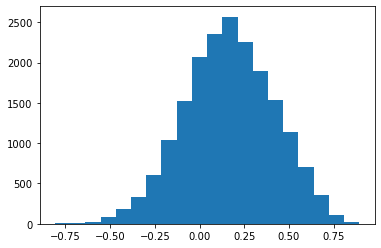

In [86]:
### same duration and timing properties (with random samples)
df_daily['food_sameDurTiming_r50_nbrbatch'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch'] = df_daily['food_sameDurTiming_r50_nbrbatch'].map(lambda x: x[3])
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch','food_sameDurTiming_r50','food_sameDurTiming_nbrbatch']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch','food_sameDurTiming_r50','food_sameDurTiming_nbrbatch']].tail(3))
plt.hist(df_daily['food_sameDurTiming_r50'], bins=20)
plt.show()

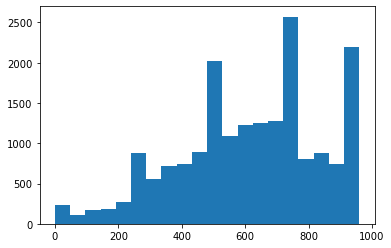

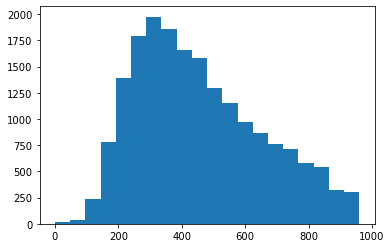

In [89]:
plt.hist(df_daily['food_sameDurTiming_tFZ_ALL'], bins=20)
plt.show()
plt.hist(df_daily['food_sameDurTiming_tFZ_ALL_FAKE'], bins=20)
plt.show()

,HenID,level,food_sameDurTiming_r50_nbrbatch_AP,food_sameDurTiming_r50_AP,food_sameDurTiming_nbrbatch_AP
43,hen_131,2020-11-14,"(0.07838888888888884, 720, 644.7466666666667, 4)",0.078389,4
44,hen_131,2020-11-15,"(0.053506944444444426, 527, 475.6333333333333, 4)",0.053507,4
45,hen_131,2020-11-16,"(0.4282222222222223, 960, 548.9066666666666, 4)",0.428222,4


,HenID,level,food_sameDurTiming_r50_nbrbatch_AP,food_sameDurTiming_r50_AP,food_sameDurTiming_nbrbatch_AP
39284,hen_98,2021-03-24,"(-0.37369444444444444, 0, 358.74666666666667, 4)",-0.373694,4
39285,hen_98,2021-03-25,"(-0.38381944444444444, 64, 432.46666666666664, 4)",-0.383819,4
39286,hen_98,2021-03-26,"(0.08281249999999996, 689, 609.5, 4)",0.082812,4


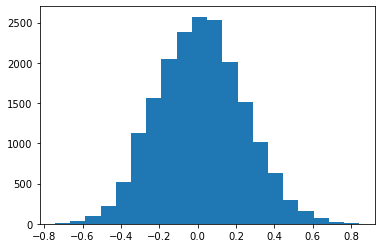

In [87]:
fake_sec_ = 20*60
df_daily['food_sameDurTiming_r50_nbrbatch_AP'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch_AP'] = df_daily['food_sameDurTiming_r50_nbrbatch_AP'].map(lambda x: x[3])
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AP','food_sameDurTiming_r50_AP','food_sameDurTiming_nbrbatch_AP']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AP','food_sameDurTiming_r50_AP','food_sameDurTiming_nbrbatch_AP']].tail(3))
plt.hist(df_daily['food_sameDurTiming_r50_AP'], bins=20)
plt.show()

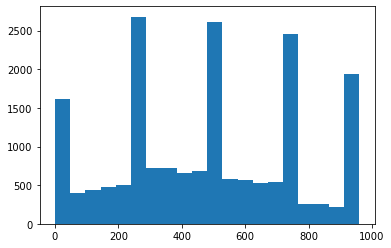

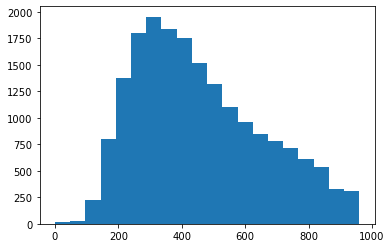

In [90]:
plt.hist(df_daily['food_sameDurTiming_tFZ_ALL_AP'], bins=20)
plt.show()
plt.hist(df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AP'], bins=20)
plt.show()

,HenID,level,food_sameDurTiming_r50_nbrbatch_AB,food_sameDurTiming_r50_AB,food_sameDurTiming_nbrbatch_AB
43,hen_131,2020-11-14,"(-0.1832407407407407, 356, 487.93333333333334, 3)",-0.183241,3
44,hen_131,2020-11-15,"(0.21400000000000008, 714, 508.55999999999995, 4)",0.214000,4
45,hen_131,2020-11-16,"(0.1717430555555557, 720, 555.1266666666666, 4)",0.171743,4


,HenID,level,food_sameDurTiming_r50_nbrbatch_AB,food_sameDurTiming_r50_AB,food_sameDurTiming_nbrbatch_AB
39284,hen_98,2021-03-24,"(-0.012342592592592572, 205, 213.8866666666666...",-0.012343,3
39285,hen_98,2021-03-25,"(-0.03212962962962962, 240, 263.1333333333333, 3)",-0.032130,3
39286,hen_98,2021-03-26,"(0.10362499999999997, 694, 594.52, 4)",0.103625,4


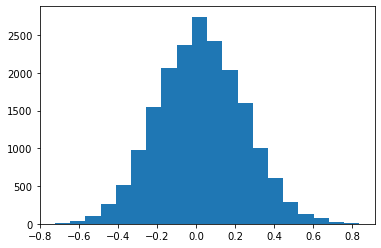

In [88]:
fake_sec_ = -20*60
df_daily['food_sameDurTiming_r50_nbrbatch_AB'] = df_daily['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=50, fake_sec=fake_sec_,
                                                                                                            dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
#df_daily.loc[df_daily['food_sameDurTiming_r50_nbrbatch'].isnull(),'food_sameDurTiming_r50_nbrbatch'] = 9
df_daily['food_sameDurTiming_r50_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[0])
df_daily['food_sameDurTiming_tFZ_ALL_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[1])
df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[2])
df_daily['food_sameDurTiming_nbrbatch_AB'] = df_daily['food_sameDurTiming_r50_nbrbatch_AB'].map(lambda x: x[3])
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AB','food_sameDurTiming_r50_AB','food_sameDurTiming_nbrbatch_AB']].head(3))
display(df_daily[['HenID','level','food_sameDurTiming_r50_nbrbatch_AB','food_sameDurTiming_r50_AB','food_sameDurTiming_nbrbatch_AB']].tail(3))
plt.hist(df_daily['food_sameDurTiming_r50_AB'], bins=20)
plt.show()

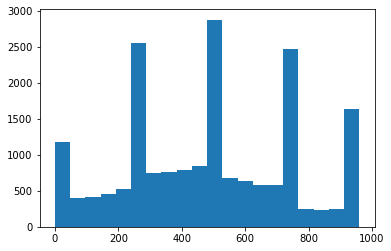

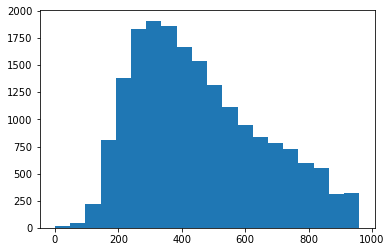

In [91]:
plt.hist(df_daily['food_sameDurTiming_tFZ_ALL_AB'], bins=20)
plt.show()
plt.hist(df_daily['food_sameDurTiming_tFZ_ALL_FAKE_AB'], bins=20)
plt.show()

### visual

,HenID,level,PenID,variable,food_behavior,is_negative
0,hen_131,2020-11-14,10,food_sameDurTiming_r50,0.275986,0
1,hen_131,2020-11-15,10,food_sameDurTiming_r50,0.225667,0
2,hen_131,2020-11-16,10,food_sameDurTiming_r50,-0.309069,1


,variable,level,is_negative
0,food_sameDurTiming_r50,2020-11-14,39.102564
1,food_sameDurTiming_r50,2020-11-15,30.128205
2,food_sameDurTiming_r50,2020-11-16,21.794872


,variable,mean_is_negative,sd_is_negative
0,food_sameDurTiming_r50,25.086617,3.802988
1,food_sameDurTiming_r50_AB,45.719655,5.263463
2,food_sameDurTiming_r50_AP,47.281368,3.933779


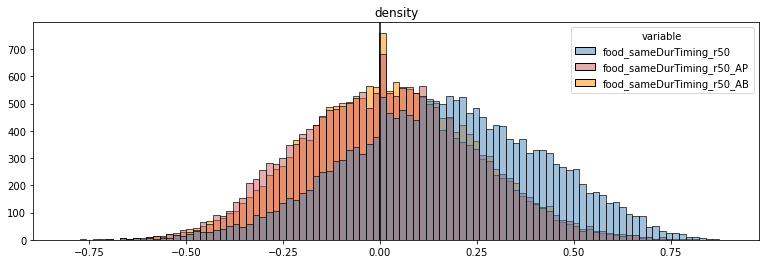

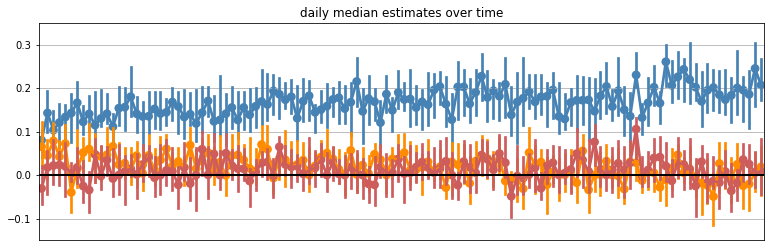

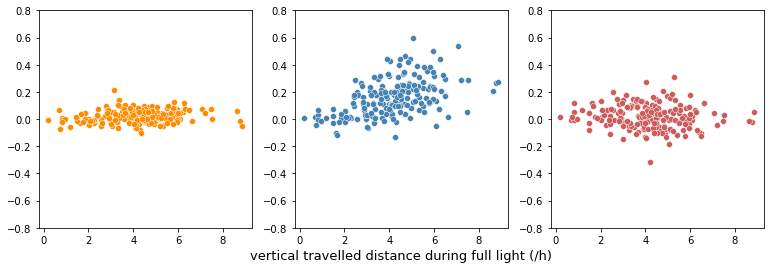

In [121]:
df_plt = pd.melt(df_daily, id_vars=['HenID','level','PenID'], 
        value_vars=['food_sameDurTiming_r50','food_sameDurTiming_r50_AP','food_sameDurTiming_r50_AB'],
        value_name='food_behavior')
df_plt['is_negative'] = df_plt['food_behavior'].map(lambda x: int(x<0))
display(df_plt.head(3))
df_plt_ = df_plt.groupby(['variable','level'])['is_negative'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
display(df_plt_.groupby(['variable']).agg(mean_is_negative=pd.NamedAgg(column='is_negative', aggfunc=lambda x: np.nanmean(x)),
           sd_is_negative=pd.NamedAgg(column='is_negative', aggfunc=lambda x: np.std(x))).reset_index())
#weekly average +-SD of the mean daily food-related behavior across individuals
plt.figure(figsize=(13,4))
pal_ = {'food_sameDurTiming_r50_AB':'darkorange',
        'food_sameDurTiming_r50_AP':'indianred',
        'food_sameDurTiming_r50':'steelblue'}
sns.histplot(df_plt, x='food_behavior', kde=False, hue='variable', palette=pal_);
plt.ylabel('')
plt.xlabel('')
plt.title('density')
plt.axvline(0, color='black');
#plt.savefig(os.path.join(path_extracted_data, 'dfBS_FoodRI_density.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

##############################################################################################################################
plt.figure(figsize=(13,4))
sns.pointplot(y='food_sameDurTiming_r50', x='DIB', color=pal_['food_sameDurTiming_r50'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_sameDurTiming_r50_AB', x='DIB', color=pal_['food_sameDurTiming_r50_AB'], data=df_daily, 
              estimator=np.median);
sns.pointplot(y='food_sameDurTiming_r50_AP', x='DIB', color=pal_['food_sameDurTiming_r50_AP'], data=df_daily, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.ylim((-0.15, 0.35))
plt.title('daily median estimates over time')
plt.xticks([])
plt.ylabel('')
plt.xlabel('')
plt.grid()
#plt.savefig(os.path.join(path_extracted_data, 'dfBS_FoodRI_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()


##############################################################################################################################
l=1
c=3
fig = plt.figure(figsize=(13,4)) #/100 si trop grand nbr
df_plt = df_daily.groupby(['HenID']).mean().reset_index()
plt.subplot(l,c,1)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_AB',
                color=pal_['food_sameDurTiming_r50_AB'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('food reactivity index backward push')
plt.xlabel('')
plt.ylim((-0.8, 0.8))
plt.yticks(fontsize=10)

plt.subplot(l,c,2)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50',
                color=pal_['food_sameDurTiming_r50'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('hens\' mean value')
plt.xlabel('vertical travelled distance during full light (/h)', size=13)
plt.ylim((-0.8, 0.8))

plt.subplot(l,c,3)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_AP',
                color=pal_['food_sameDurTiming_r50_AP'])#,  size="size", sizes=(20, 200))
plt.xlabel('')
plt.ylabel('')
#plt.title('food reactivity index')
plt.ylim((-0.8, 0.8))

#plt.savefig(os.path.join(path_extracted_data,'dfBS_Raw_VTD_food.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();

(56457, 5)


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,HenID,level,PenID,variable,tFZ_ALL
0,hen_131,2020-11-14,10,food_sameDurTiming_tFZ_ALL,869
1,hen_131,2020-11-15,10,food_sameDurTiming_tFZ_ALL,720
2,hen_131,2020-11-16,10,food_sameDurTiming_tFZ_ALL,240


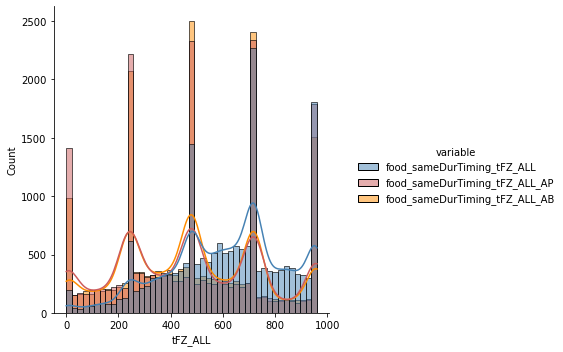

(56457, 5)


C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  exec(code_obj, self.user_global_ns, self.user_ns)


,HenID,level,PenID,variable,tFZ_ALL
0,hen_131,2020-11-14,10,food_sameDurTiming_tFZ_ALL_FAKE,604.053333
1,hen_131,2020-11-15,10,food_sameDurTiming_tFZ_ALL_FAKE,503.360000
2,hen_131,2020-11-16,10,food_sameDurTiming_tFZ_ALL_FAKE,536.706667


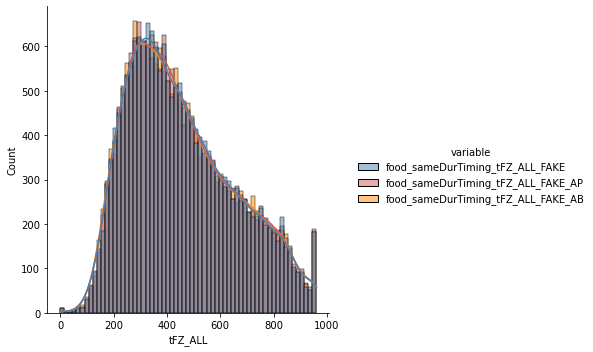

In [153]:
li_val = ['food_sameDurTiming_tFZ_ALL', 'food_sameDurTiming_tFZ_ALL_AP', 'food_sameDurTiming_tFZ_ALL_AB']
pal_ = {'food_sameDurTiming_tFZ_ALL_AB':'darkorange',
        'food_sameDurTiming_tFZ_ALL_AP':'indianred',
        'food_sameDurTiming_tFZ_ALL':'steelblue'}
df_daily_melt = pd.melt(df_daily, id_vars=['HenID','level','PenID'], value_vars=li_val, value_name = 'tFZ_ALL')
print(df_daily_melt.shape)
display(df_daily_melt.head(3))
sns.displot(df_daily_melt, x="tFZ_ALL", hue="variable", kde=True, palette=pal_)
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_tFZ_ALL.png'),dpi=300,format='png',bbox_inches='tight');
plt.show();

li_val = ['food_sameDurTiming_tFZ_ALL_FAKE', 'food_sameDurTiming_tFZ_ALL_FAKE_AP', 'food_sameDurTiming_tFZ_ALL_FAKE_AB']
pal_ = {'food_sameDurTiming_tFZ_ALL_FAKE_AB':'darkorange',
        'food_sameDurTiming_tFZ_ALL_FAKE_AP':'indianred',
        'food_sameDurTiming_tFZ_ALL_FAKE':'steelblue'}
df_daily_melt = pd.melt(df_daily, id_vars=['HenID','level','PenID'], value_vars=li_val, value_name = 'tFZ_ALL')
print(df_daily_melt.shape)
display(df_daily_melt.head(3))
sns.displot(df_daily_melt, x="tFZ_ALL", hue="variable", kde=True, palette=pal_)
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_tFZ_ALL_FAKE.png'),dpi=300,format='png',bbox_inches='tight');

### sensitivity to number of random samples

In [129]:
### same duration and timing properties (with random samples)
df_ = df_daily[df_daily['PenID'].isin([3,4,5])].copy()
#with only 1-10 random sample
for nbr_ in tqdm.tqdm(range(1, 10, 2)):
    df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'] = df_['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=nbr_,
                                                                                                                dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
    df_['food_sameDurTiming_r'+str(nbr_)] = df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'].map(lambda x: x[0])
    df_['food_sameDurTiming_tFZ_ALL'+str(nbr_)] = df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'].map(lambda x: x[1])
    df_['food_sameDurTiming_tFZ_ALL_FAKE'+str(nbr_)] = df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'].map(lambda x: x[2])
    df_['food_sameDurTiming_nbrbatch'+str(nbr_)] = df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'].map(lambda x: x[3])

#with every 10 more r. samples
for nbr_ in tqdm.tqdm(range(10 ,120, 20)):
    df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'] = df_['list_ZALL'].map(lambda x: food_SameDurationProperties(li_Z=eval(x), config=config, Nbr_random=nbr_,
                                                                                                                dico_nbr_liFAKEdate=dico_nbr_liFAKEdate, tupleFR_h_mn=tupleFR_h_mn))
    df_['food_sameDurTiming_r'+str(nbr_)] = df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'].map(lambda x: x[0])
    df_['food_sameDurTiming_tFZ_ALL'+str(nbr_)] = df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'].map(lambda x: x[1])
    df_['food_sameDurTiming_tFZ_ALL_FAKE'+str(nbr_)] = df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'].map(lambda x: x[2])
    df_['food_sameDurTiming_nbrbatch'+str(nbr_)] = df_['food_sameDurTiming_r'+str(nbr_)+'_nbrbatch'].map(lambda x: x[3])
    
display(df_.head(5))

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:10:33<00:00, 705.58s/it]


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,food_sameDurTiming_r90_nbrbatch,food_sameDurTiming_r90,food_sameDurTiming_tFZ_ALL90,food_sameDurTiming_tFZ_ALL_FAKE90,food_sameDurTiming_nbrbatch90,food_sameDurTiming_r110_nbrbatch,food_sameDurTiming_r110,food_sameDurTiming_tFZ_ALL110,food_sameDurTiming_tFZ_ALL_FAKE110,food_sameDurTiming_nbrbatch110
14886,hen_102,2020-11-14,1740.0,5527.0,929.0,7078.0,38726.0,54000.0,15.0,"[1740.0, 5527.0, 929.0, 7078.0, 38726.0]",...,"(-0.06711033950617273, 720, 784.4259259259259, 4)",-0.067110,720,784.425926,4,"(-0.05746212121212113, 720, 775.1636363636363, 4)",-0.057462,720,775.163636,4
14887,hen_102,2020-11-15,334.0,2161.0,4151.0,4466.0,42888.0,54000.0,15.0,"[334.0, 2161.0, 4151.0, 4466.0, 42888.0]",...,"(0.1891280864197531, 960, 778.437037037037, 4)",0.189128,960,778.437037,4,"(0.19683712121212127, 960, 771.0363636363636, 4)",0.196837,960,771.036364,4
14888,hen_102,2020-11-16,534.0,1342.0,2303.0,2436.0,47385.0,54000.0,15.0,"[534.0, 1342.0, 2303.0, 2436.0, 47385.0]",...,"(-0.17492283950617282, 720, 887.9259259259259, 4)",-0.174923,720,887.925926,4,"(-0.1607070707070707, 720, 874.2787878787879, 4)",-0.160707,720,874.278788,4
14889,hen_102,2020-11-17,1061.0,4730.0,843.0,3694.0,43672.0,54000.0,15.0,"[1061.0, 4730.0, 843.0, 3694.0, 43672.0]",...,"(0.23976080246913578, 960, 729.8296296296296, 4)",0.239761,960,729.829630,4,"(0.23538825757575765, 960, 734.0272727272727, 4)",0.235388,960,734.027273,4
14890,hen_102,2020-11-18,1427.0,3578.0,255.0,7657.0,41083.0,54000.0,15.0,"[1427.0, 3578.0, 255.0, 7657.0, 41083.0]",...,"(0.03878472222222229, 720, 682.7666666666667, 4)",0.038785,720,682.766667,4,"(0.054551767676767726, 720, 667.630303030303, 4)",0.054552,720,667.630303,4


In [5]:
#daily var
df_ = pd.read_csv(os.path.join(path_extracted_data, 'FOOD_df_randomssample_pen345.csv'), sep=',') 
print(df_.shape)
df_.head(3)

(7066, 80)


,HenID,PenID,level,food_reactivity_index,food_reactivity_index_forward,food_reactivity_index_backward,food_related_behavior4,food_related_behavior_rp4,food_related_behavior_rm4,food_sameDurTiming_r50_nbrbatch,...,food_sameDurTiming_r90_nbrbatch,food_sameDurTiming_r90,food_sameDurTiming_tFZ_ALL90,food_sameDurTiming_tFZ_ALL_FAKE90,food_sameDurTiming_nbrbatch90,food_sameDurTiming_r110_nbrbatch,food_sameDurTiming_r110,food_sameDurTiming_tFZ_ALL110,food_sameDurTiming_tFZ_ALL_FAKE110,food_sameDurTiming_nbrbatch110
0,hen_102,3,2020-11-14,-0.088858,-0.237790,0.013827,-0.091830,-0.178171,-0.066886,"(-0.049833333333333396, 720, 767.84, 4)",...,"(-0.06711033950617273, 720, 784.4259259259259, 4)",-0.067110,720,784.425926,4,"(-0.05746212121212113, 720, 775.1636363636363, 4)",-0.057462,720,775.163636,4
1,hen_102,3,2020-11-15,0.086027,-0.024126,0.088914,0.083143,-0.072307,0.088914,"(0.1761597222222222, 960, 790.8866666666667, 4)",...,"(0.1891280864197531, 960, 778.437037037037, 4)",0.189128,960,778.437037,4,"(0.19683712121212127, 960, 771.0363636363636, 4)",0.196837,960,771.036364,4
2,hen_102,3,2020-11-16,-0.063879,0.046206,-0.101181,0.005034,0.046877,-0.116767,"(-0.18027777777777776, 720, 893.0666666666666, 4)",...,"(-0.17492283950617282, 720, 887.9259259259259, 4)",-0.174923,720,887.925926,4,"(-0.1607070707070707, 720, 874.2787878787879, 4)",-0.160707,720,874.278788,4


In [29]:
li_val = [i for i in df_.columns if ('food_sameDurTiming_r' in i) & (len(i.split('_'))==3)]
print(li_val)
df_melt = pd.melt(df_, id_vars=['HenID','level','PenID'], value_vars=li_val, value_name = 'food_reactivity')
df_melt['number of random samples'] = df_melt['variable'].map(lambda x: x.split('_r')[-1])
df_melt['#rs'] = df_melt['variable'].map(lambda x: int(x.split('_r')[-1]))

print(df_melt.shape)
display(df_melt.head(3))


['food_sameDurTiming_r50', 'food_sameDurTiming_r1', 'food_sameDurTiming_r3', 'food_sameDurTiming_r5', 'food_sameDurTiming_r7', 'food_sameDurTiming_r9', 'food_sameDurTiming_r10', 'food_sameDurTiming_r30', 'food_sameDurTiming_r70', 'food_sameDurTiming_r90', 'food_sameDurTiming_r110']
(77726, 7)


,HenID,level,PenID,variable,food_reactivity,number of random samples,#rs
0,hen_102,2020-11-14,3,food_sameDurTiming_r50,-0.049833,50,50
1,hen_102,2020-11-15,3,food_sameDurTiming_r50,0.176160,50,50
2,hen_102,2020-11-16,3,food_sameDurTiming_r50,-0.180278,50,50


['food_sameDurTiming_r50', 'food_sameDurTiming_r1', 'food_sameDurTiming_r3', 'food_sameDurTiming_r5', 'food_sameDurTiming_r7', 'food_sameDurTiming_r9', 'food_sameDurTiming_r10', 'food_sameDurTiming_r30', 'food_sameDurTiming_r70', 'food_sameDurTiming_r90', 'food_sameDurTiming_r110']
(77726, 6)


,HenID,level,PenID,variable,food_reactivity,number of random samples
0,hen_102,2020-11-14,3,food_sameDurTiming_r50,-0.049833,50
1,hen_102,2020-11-15,3,food_sameDurTiming_r50,0.176160,50
2,hen_102,2020-11-16,3,food_sameDurTiming_r50,-0.180278,50


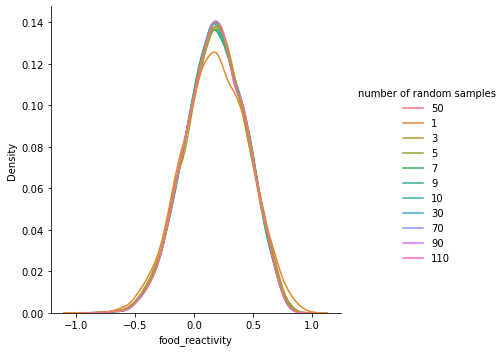

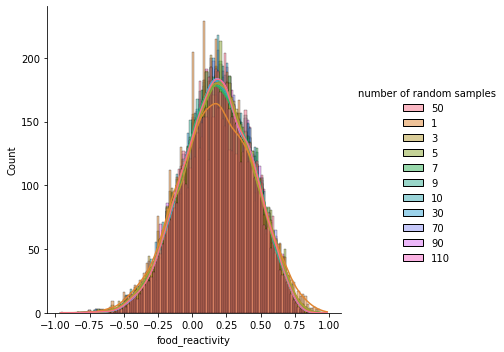

In [6]:
sns.displot(df_melt, x="food_reactivity", hue="number of random samples", kind="kde", fill=False);
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_nbrsamples_v1.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();

sns.displot(df_melt, x="food_reactivity", hue="number of random samples", kde=True)
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_nbrsamples_v2.png'),dpi=300,format='png',bbox_inches='tight');
plt.show();

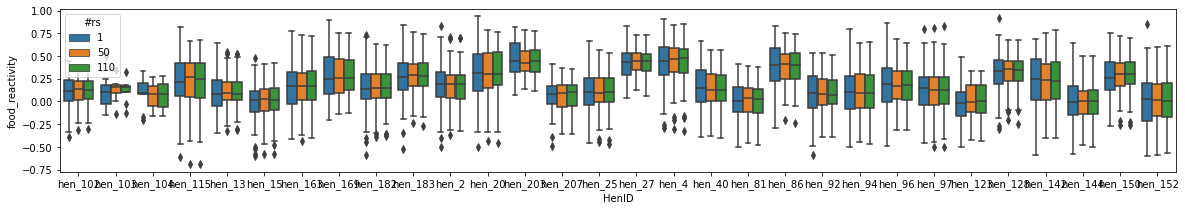

In [37]:
plt.figure(figsize=(20,3))
sns.boxplot(x='HenID',y='food_reactivity', hue='#rs', 
            data=df_melt[(df_melt['HenID'].isin(df_melt['HenID'].unique()[0:30]))&\
                        (df_melt['#rs'].isin([1,50,110]))]);
# no diff!

### sensitivity to number batch used

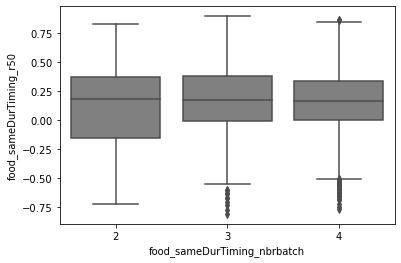

In [139]:
sns.boxplot(x='food_sameDurTiming_nbrbatch', y='food_sameDurTiming_r50', data=df_daily, color='grey');
plt.savefig(os.path.join(path_extracted_data, 'FoodRI2_nbrbatch.png'),dpi=300,format='png',bbox_inches='tight');
plt.show();

# Save

In [149]:
#save
li_ = [i for i in df_.columns if 'food' in i]
df_[['HenID','PenID','level']+li_].to_csv(os.path.join(path_extracted_data,'FOOD_df_randomssample_pen345.csv'), index=False, sep=',')
li_ = [i for i in df_daily.columns if ('food' in i)|('travel_' in i)]
df_daily[['HenID','PenID','level']+li_].to_csv(os.path.join(path_extracted_data,'FOOD_df_foodindexcomparison.csv'), index=False, sep=',')